In [1]:
import pandas as pd
import numpy as np
import os
import pydicom
from tqdm import tqdm
from skimage.io import imsave
import cv2
import pickle
import gzip

In [2]:
data_path = 'manifest-1728399616919'
boxes_path = 'Annotation_Boxes.xlsx'
mapping_path = 'Breast-Cancer-MRI-filepath_filename-mapping.xlsx'
target_png_dir = 'png_im_out'
if not os.path.exists(target_png_dir):
    os.makedirs(target_png_dir)

# Load clinical and demographic data from the Excel file
clinical_data_path = 'Clinical_and_Other_Features.xlsx'

# Define the path to the image folder
image_folder = 'png_im_out/pos'

In [3]:
boxes_df = pd.read_excel(boxes_path)
display(boxes_df) 

,Patient ID,Start Row,End Row,Start Column,End Column,Start Slice,End Slice
0,Breast_MRI_001,234,271,308,341,89,112
1,Breast_MRI_002,251,294,108,136,59,72
2,Breast_MRI_003,351,412,82,139,96,108
3,Breast_MRI_004,262,280,193,204,86,95
4,Breast_MRI_005,188,213,138,178,76,122
...,...,...,...,...,...,...,...
917,Breast_MRI_918,345,395,338,395,62,85
918,Breast_MRI_919,285,312,369,397,98,109
919,Breast_MRI_920,172,193,337,355,87,101
920,Breast_MRI_921,328,374,404,446,97,121


In [8]:
#only consider fat-saturated "pre" exams
mapping_df = pd.read_excel(mapping_path)

display(mapping_df)

,sop_instance_UID,original_path_and_filename,classic_path,descriptive_path,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,series_sort
0,1.3.6.1.4.1.14519.5.2.1.1805789812895034139917...,DICOM_Images/Breast_MRI_001/post_1/Breast_MRI_...,Duke-Breast-Cancer-MRI/Breast_MRI_001/1.3.6.1....,Duke-Breast-Cancer-MRI/BreastMRI001/01-01-1990...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01.dcm
1,1.3.6.1.4.1.14519.5.2.1.4903237729147735321973...,DICOM_Images/Breast_MRI_001/post_1/Breast_MRI_...,Duke-Breast-Cancer-MRI/Breast_MRI_001/1.3.6.1....,Duke-Breast-Cancer-MRI/BreastMRI001/01-01-1990...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.3.6.1.4.1.14519.5.2.1.3061160038794820079325...,DICOM_Images/Breast_MRI_001/post_1/Breast_MRI_...,Duke-Breast-Cancer-MRI/Breast_MRI_001/1.3.6.1....,Duke-Breast-Cancer-MRI/BreastMRI001/01-01-1990...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.3.6.1.4.1.14519.5.2.1.1574717199045785031549...,DICOM_Images/Breast_MRI_001/post_1/Breast_MRI_...,Duke-Breast-Cancer-MRI/Breast_MRI_001/1.3.6.1....,Duke-Breast-Cancer-MRI/BreastMRI001/01-01-1990...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.3.6.1.4.1.14519.5.2.1.2594404476894572978078...,DICOM_Images/Breast_MRI_001/post_1/Breast_MRI_...,Duke-Breast-Cancer-MRI/Breast_MRI_001/1.3.6.1....,Duke-Breast-Cancer-MRI/BreastMRI001/01-01-1990...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
773121,1.3.6.1.4.1.14519.5.2.1.2393425910452664915158...,DICOM_Images/Breast_MRI_922/T1/Breast_MRI_922_...,Duke-Breast-Cancer-MRI/Breast_MRI_922/1.3.6.1....,Duke-Breast-Cancer-MRI/BreastMRI922/01-01-1990...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
773122,1.3.6.1.4.1.14519.5.2.1.1921416620775060655567...,DICOM_Images/Breast_MRI_922/T1/Breast_MRI_922_...,Duke-Breast-Cancer-MRI/Breast_MRI_922/1.3.6.1....,Duke-Breast-Cancer-MRI/BreastMRI922/01-01-1990...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
773123,1.3.6.1.4.1.14519.5.2.1.1148085546624000943273...,DICOM_Images/Breast_MRI_922/T1/Breast_MRI_922_...,Duke-Breast-Cancer-MRI/Breast_MRI_922/1.3.6.1....,Duke-Breast-Cancer-MRI/BreastMRI922/01-01-1990...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
773124,1.3.6.1.4.1.14519.5.2.1.1929308890572593698573...,DICOM_Images/Breast_MRI_922/T1/Breast_MRI_922_...,Duke-Breast-Cancer-MRI/Breast_MRI_922/1.3.6.1....,Duke-Breast-Cancer-MRI/BreastMRI922/01-01-1990...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
#only considering fat-saturated pre-contrast images
mapping_df = mapping_df[mapping_df['original_path_and_filename'].str.contains('pre')]

#getting all patients from 1 to 917
#using regex
crossref_pattern = '|'.join(["DICOM_Images/Breast_MRI_{:03d}".format(s) for s in list(range(1, 990))])
mapping_df = mapping_df[mapping_df['original_path_and_filename'].str.contains(crossref_pattern)]

In [6]:
mapping_df

,sop_instance_UID,original_path_and_filename,classic_path,descriptive_path,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,series_sort
640,1.3.6.1.4.1.14519.5.2.1.1622543824533841316221...,DICOM_Images/Breast_MRI_001/pre/Breast_MRI_001...,Duke-Breast-Cancer-MRI/Breast_MRI_001/1.3.6.1....,Duke-Breast-Cancer-MRI/BreastMRI001/01-01-1990...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
641,1.3.6.1.4.1.14519.5.2.1.2095737470789034615864...,DICOM_Images/Breast_MRI_001/pre/Breast_MRI_001...,Duke-Breast-Cancer-MRI/Breast_MRI_001/1.3.6.1....,Duke-Breast-Cancer-MRI/BreastMRI001/01-01-1990...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
642,1.3.6.1.4.1.14519.5.2.1.7648352393594634493272...,DICOM_Images/Breast_MRI_001/pre/Breast_MRI_001...,Duke-Breast-Cancer-MRI/Breast_MRI_001/1.3.6.1....,Duke-Breast-Cancer-MRI/BreastMRI001/01-01-1990...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
643,1.3.6.1.4.1.14519.5.2.1.2333724865431423854264...,DICOM_Images/Breast_MRI_001/pre/Breast_MRI_001...,Duke-Breast-Cancer-MRI/Breast_MRI_001/1.3.6.1....,Duke-Breast-Cancer-MRI/BreastMRI001/01-01-1990...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
644,1.3.6.1.4.1.14519.5.2.1.3037519639975787441522...,DICOM_Images/Breast_MRI_001/pre/Breast_MRI_001...,Duke-Breast-Cancer-MRI/Breast_MRI_001/1.3.6.1....,Duke-Breast-Cancer-MRI/BreastMRI001/01-01-1990...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
773061,1.3.6.1.4.1.14519.5.2.1.1620326542824048399612...,DICOM_Images/Breast_MRI_922/pre/Breast_MRI_922...,Duke-Breast-Cancer-MRI/Breast_MRI_922/1.3.6.1....,Duke-Breast-Cancer-MRI/BreastMRI922/01-01-1990...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
773062,1.3.6.1.4.1.14519.5.2.1.1729373208009133770295...,DICOM_Images/Breast_MRI_922/pre/Breast_MRI_922...,Duke-Breast-Cancer-MRI/Breast_MRI_922/1.3.6.1....,Duke-Breast-Cancer-MRI/BreastMRI922/01-01-1990...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
773063,1.3.6.1.4.1.14519.5.2.1.1303194464206675272654...,DICOM_Images/Breast_MRI_922/pre/Breast_MRI_922...,Duke-Breast-Cancer-MRI/Breast_MRI_922/1.3.6.1....,Duke-Breast-Cancer-MRI/BreastMRI922/01-01-1990...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
773064,1.3.6.1.4.1.14519.5.2.1.3292134909528830152433...,DICOM_Images/Breast_MRI_922/pre/Breast_MRI_922...,Duke-Breast-Cancer-MRI/Breast_MRI_922/1.3.6.1....,Duke-Breast-Cancer-MRI/BreastMRI922/01-01-1990...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
def save_dcm_slice(dcm_fname, label, patient_id, slice_number):
    # create a path to save the slice .png file in, according to the original DICOM filename and target label
    png_path = f"{patient_id}-{slice_number}.png" #make the file name of the png file like patientId-sliceId
    label_dir = 'pos' if label == 1 else 'neg' #different folders for positive and negative labeled images
    png_path = os.path.join(target_png_dir, label_dir, png_path) #png file path, target_png_dir defined first, then according to label put the file in pos or neg

        
    if not os.path.exists(os.path.join(target_png_dir, label_dir)):
        os.makedirs(os.path.join(target_png_dir, label_dir))
    
    if not os.path.exists(png_path):
        # Only make the png image if it doesn't already exist (if you're running this after the first time)
        try:
            # Load DICOM file with pydicom library
            dcm = pydicom.dcmread(dcm_fname)
        except FileNotFoundError:
            #print(f"File not found: {dcm_fname}, skipping.")
            return

        # convert DICOM into numerical numpy array of pixel intensity values
        img = dcm.pixel_array

        # convert uint16 datatype to float, scaled properly for uint8
        img = img.astype(np.float64) * 255. / img.max()
        # convert from float -> uint8
        img = img.astype(np.uint8)
        # invert image if necessary, according to DICOM metadata
        img_type = dcm.PhotometricInterpretation
        if img_type == "MONOCHROME1":
            img = np.invert(img)

        # save final .png
        imsave(png_path, img)


In [8]:
# number of examples for each class
N_class = 2600
# counts of examples extracted from each class
ct_negative = 0
ct_positive = 0

# initialize iteration index of each patient volume
vol_idx = -1
for row_idx, row in tqdm(mapping_df.iterrows()): #from the reduced mapping file containing the 100 patients, the rows are genrated
    # Extract patient ID and slice number from the file path
    original_path = row['original_path_and_filename'] #the path of the dicom file
    patient_id = original_path.split('/')[1].split('_')[2] #take the 2nd part after splitting at / and the 3rd part of that after splitting with _
    slice_number = int(original_path.split('_')[-1].replace('.dcm', '')) #take the last part after splitting at _. replace the .dcm with blank 
    
    # new volume: get tumor bounding box
    new_vol_idx = int(patient_id)
    if new_vol_idx != vol_idx:
        box_row = boxes_df.iloc[new_vol_idx - 1]
        start_slice = int(box_row['Start Slice'])
        end_slice = int(box_row['End Slice'])
        assert end_slice >= start_slice
    vol_idx = new_vol_idx

    # get DICOM filename
    dcm_fname = str(row['classic_path'])
    dcm_fname = os.path.join(data_path, dcm_fname)
    
    # determine slice label:
    # (1) if within 3D box, save as positive
    if slice_number >= start_slice and slice_number < end_slice: 
        save_dcm_slice(dcm_fname, 1, patient_id, slice_number)
        ct_positive += 1

    # (2) if outside 3D box by >5 slices, save as negative
#    elif (slice_number + 5) <= start_slice or (slice_number - 5) > end_slice:
#        if ct_negative >= N_class:
#            continue
#        save_dcm_slice(dcm_fname, 0, patient_id, slice_number)
#        ct_negative += 1


157198it [05:33, 471.80it/s] 


Displaying image: png_im_out/pos/512-46.png


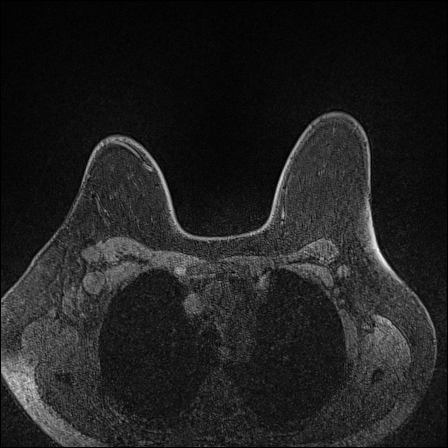

In [4]:
from IPython.display import Image, display
from random import choice
import os

# Display a random positive image and its filename
positive_image_dir = os.path.join(target_png_dir, 'pos')
positive_image_filenames = os.listdir(positive_image_dir)
sample_image_path = os.path.join(positive_image_dir, choice(positive_image_filenames))

# Display the randomly selected image and its filename
print(f"Displaying image: {sample_image_path}")
display(Image(filename=sample_image_path))

In [5]:
#Loading entire 
clinical_data = pd.read_excel(clinical_data_path)

# Extract relevant columns and rename for consistency
clinical_data = clinical_data[['Patient ID', 'Pathologic Response to Neoadjuvant Therapy'] + [col for col in clinical_data.columns if col.startswith('Breast_MRI_')]]
clinical_data.columns = [col.replace(' ', '_') for col in clinical_data.columns]
clinical_data = clinical_data.rename(columns={'Patient_ID': 'patient_id', 'Pathologic_Response_to_Neoadjuvant_Therapy': 'response'})

# Convert 'Breast_MRI_001' to '001' in the patient_id column
clinical_data['patient_id'] = clinical_data['patient_id'].apply(lambda x: x.split('_')[-1])

# Convert response to binary: 1 means response, anything other than 1 means no response
clinical_data['response'] = clinical_data['response'].apply(lambda x: 1 if x == 1 else 0)

In [11]:
# Function to load and preprocess images
def load_images(image_folder, clinical_data):
    images = {}
    for filename in os.listdir(image_folder):
        if filename.endswith('.png'):
            patient_id = filename.split('-')[0]
            if patient_id in clinical_data['patient_id'].astype(str).values:
                image_name = filename[:-4]  # Remove the '.png' part
                image_path = os.path.join(image_folder, filename)
                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                images[image_name] = image
    return images

# Load images
image_data = load_images(image_folder, clinical_data)


In [12]:
# Save the image data to a compressed file
image_data_path = f'image_data_{data_path}.pkl.gz'
with gzip.open(image_data_path, 'wb') as f:
    pickle.dump(image_data, f, protocol=pickle.HIGHEST_PROTOCOL)
print(f"Saved compressed image data to {image_data_path}.")

Saved compressed image data to image_data_manifest-1728399616919.pkl.gz.


In [13]:
# Get the number of distinct keys
num_keys = len(image_data)
print(f"The number of distinct keys is: {num_keys}")

# Get the list of keys
keys = list(image_data.keys())
print("The keys are:", keys)

The number of distinct keys is: 8660
The keys are: ['717-61', '132-92', '285-86', '258-123', '850-69', '228-72', '148-58', '385-92', '385-86', '679-119', '321-56', '228-66', '717-75', '285-92', '132-86', '258-137', '663-86', '198-53', '148-64', '636-87', '679-131', '558-94', '148-70', '636-93', '679-125', '091-77', '287-103', '642-74', '198-47', '717-49', '776-100', '060-121', '160-71', '385-111', '321-81', '636-78', '255-72', '395-105', '395-111', '255-66', '805-97', '160-65', '091-88', '385-105', '776-114', '056-137', '328-99', '891-109', '285-79', '850-96', '046-123', '041-97', '385-79', '525-94', '850-82', '046-137', '041-83', '663-79', '776-128', '198-84', '123-114', '160-59', '385-139', '833-96', '437-113', '607-64', '148-103', '685-73', '317-80', '338-63', '685-67', '307-118', '652-59', '546-94', '441-89', '395-97', '437-107', '607-70', '915-79', '609-75', '156-58', '177-96', '812-64', '307-130', '414-88', '345-88', '652-71', '077-96', '652-65', '307-124', '812-70', '874-131', '

In [16]:
# Define the path for the folder where expanded tumor images will be stored
expanded_tumor_png_dir = 'png_expanded_tumor_out_5'
if not os.path.exists(expanded_tumor_png_dir):
    os.makedirs(expanded_tumor_png_dir)

def save_expanded_tumor_slice(dcm_fname, patient_id, slice_number, box_row):
    # Create the path to save the expanded tumor .png file
    png_path = f"{patient_id}-{slice_number}.png"
    png_path = os.path.join(expanded_tumor_png_dir, png_path)

    if not os.path.exists(png_path):
        try:
            # Load DICOM file with pydicom library
            dcm = pydicom.dcmread(dcm_fname)
        except FileNotFoundError:
            return

        # Convert DICOM into numerical numpy array of pixel intensity values
        img = dcm.pixel_array
        img_height, img_width = img.shape

        # Get original bounding box coordinates
        start_row = int(box_row['Start Row'])
        end_row = int(box_row['End Row'])
        start_col = int(box_row['Start Column'])
        end_col = int(box_row['End Column'])

        # Calculate the current area and the expansion factor
        original_area = (end_row - start_row) * (end_col - start_col)
        target_area = 5 * original_area
        expansion_factor = np.sqrt(target_area / original_area)

        # Calculate new width and height based on the expansion factor
        expanded_height = int((end_row - start_row) * expansion_factor)
        expanded_width = int((end_col - start_col) * expansion_factor)

        # Calculate the center of the original box
        center_row = (start_row + end_row) // 2
        center_col = (start_col + end_col) // 2

        # Calculate the new expanded bounding box, ensuring it doesn't exceed image boundaries
        new_start_row = max(0, center_row - expanded_height // 2)
        new_end_row = min(img_height, center_row + expanded_height // 2)
        new_start_col = max(0, center_col - expanded_width // 2)
        new_end_col = min(img_width, center_col + expanded_width // 2)

        # Crop the image to the expanded bounding box
        img_expanded = img[new_start_row:new_end_row, new_start_col:new_end_col]

        # Convert uint16 datatype to float, scaled properly for uint8
        img_expanded = img_expanded.astype(np.float64) * 255. / img_expanded.max()
        img_expanded = img_expanded.astype(np.uint8)  # Convert from float -> uint8

        # Invert image if necessary, according to DICOM metadata
        img_type = dcm.PhotometricInterpretation
        if img_type == "MONOCHROME1":
            img_expanded = np.invert(img_expanded)

        # Save final expanded .png
        imsave(png_path, img_expanded)
vol_idx = -1
# Iterate over the same patient slices and save the expanded tumor regions
for row_idx, row in tqdm(mapping_df.iterrows()):
    original_path = row['original_path_and_filename']
    patient_id = original_path.split('/')[1].split('_')[2]
    patient_id1 = original_path.split('/')[1]
    slice_number = int(original_path.split('_')[-1].replace('.dcm', ''))
    
    new_vol_idx = int(patient_id)
    if new_vol_idx != vol_idx:
        box_row = boxes_df[boxes_df['Patient ID'] == patient_id1].iloc[0]
        start_slice = int(box_row['Start Slice'])
        end_slice = int(box_row['End Slice'])
        assert end_slice >= start_slice
    vol_idx = new_vol_idx

    dcm_fname = os.path.join(data_path, str(row['classic_path']))

    if start_slice <= slice_number < end_slice:
        save_expanded_tumor_slice(dcm_fname, patient_id, slice_number, box_row)


0it [00:00, ?it/s]

157198it [01:21, 1928.86it/s]
